In [186]:
import urllib3
import pandas as pd
from io import StringIO
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
%matplotlib inline

#### Load the data to dataframes

In [187]:
http = urllib3.PoolManager()
urls = ['https://raw.githubusercontent.com/uwescience/datasci_course_materials/master/assignment6/seattle_incidents_summer_2014.csv',
        'https://raw.githubusercontent.com/uwescience/datasci_course_materials/master/assignment6/sanfrancisco_incidents_summer_2014.csv',
        ]
cities = ['seattle', 'san_francisco']
data = {}
for city, url  in zip(cities,urls):
    r = http.request('GET', url)
    data[city] = r.data.decode('utf-8')
print(type(data['seattle']))
df_seattle = pd.read_csv(StringIO(data['seattle']), sep=',', parse_dates=['Date Reported', 'Occurred Date or Date Range Start', 'Occurred Date Range End'])
df_friso   = pd.read_csv(StringIO(data['san_francisco']), sep=',')

<class 'str'>


#### clean / prepare data

In [188]:
t_min = min(df_seattle['Occurred Date or Date Range Start'])
t_max = max(df_seattle['Occurred Date or Date Range Start'])
print(f'Crimes reported happened between {t_min.date()} and {t_max.date()}')
# filter records that have strange longitude
df_seattle = df_seattle[df_seattle['Longitude']<0]
# put some additional features to later group by
df_seattle['counter'] = 1
df_seattle['hour'] = [x.hour for x in df_seattle['Occurred Date or Date Range Start']]
df_seattle['dayofweek'] = [x.dayofweek for x in df_seattle['Occurred Date or Date Range Start']]
#crimes = df_seattle.groupby('Offense Type')['counter'].sum().sort_values(ascending=False)

Crimes reported happened between 2014-06-01 and 2014-08-31


#### lets have a look on crimes related to prostitution

['PROSTITUTION-ASSIST-PROMOTE', 'PROSTITUTION', 'PROSTITUTION PATRONIZING', 'PROSTITUTION LOITERING']


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

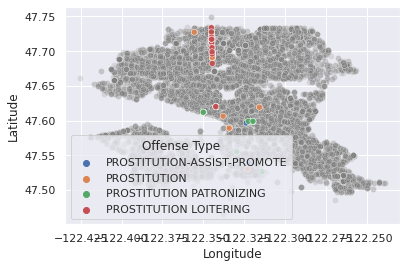

In [189]:
prostitution_crimes = [c for c in df_seattle['Offense Type'].unique() if 'PROSTITUTION' in c]
print(prostitution_crimes)
df_pros = df_seattle[df_seattle['Offense Type'].isin(prostitution_crimes)]
sns.scatterplot(data=df_seattle, x='Longitude', y='Latitude', alpha=0.2, color='grey')
sns.scatterplot(data=df_pros, x='Longitude', y='Latitude', hue='Offense Type', alpha=0.7)
#plt.close()

Interesting, it seems there is like a street where Prostitution seems to take place, lets cluster using DBSCAN

 1    129
-1     22
 3     21
 0     18
 2     12
Name: cluster_label, dtype: int64


/home/dominik/anaconda3/envs/untitled/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


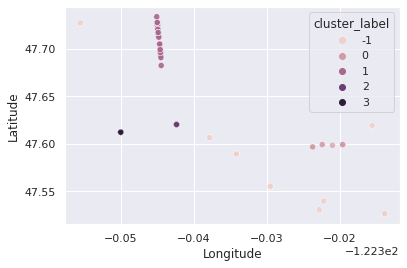

In [190]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN
#g = sns.scatterplot(data=df_seattle, x='Longitude', y='Latitude', alpha=0.2)
Z = list(zip(df_pros['Longitude'], df_pros['Latitude']))
clustering = DBSCAN(eps=0.01, min_samples=10).fit(Z)
df_pros['cluster_label'] = clustering.labels_
g = sns.scatterplot(data=df_pros, x='Longitude', y='Latitude', hue='cluster_label', alpha=0.7)
print(df_pros['cluster_label'].value_counts())
#g.set(xlim=(-122.4, -122.3))
#g.set(ylim=(47.6, 47.85))

The cluster 1 is the one looks like to be at the street. First hit on google shows that the Aurora Avenue is known for prostitution
Even with min_sample 10 there seem to be some hotspots spread throughout the city

#### Lets finish with having a look at the weekdays and times those crimes occur:

<AxesSubplot:xlabel='dayofweek', ylabel='hour'>

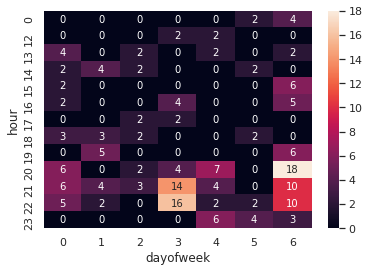

In [191]:
grouped = df_pros.groupby(['dayofweek','hour'])['counter'].sum().reset_index() #unstack()
piv = grouped.pivot('hour', 'dayofweek','counter').fillna(0)
sns.heatmap(piv, annot=True)

Day 0 is Monday and day 6 stands for Sunday.
I would have expected the most crimes to happen on Saturday night, but interestingly, it seems that Sunday and Thursday!? are prone for crimes in Prostitution
#### This little exercise gave us some insights about prostitution in Seattle, underlay by some simple yet insightful graphs